In [33]:
import os

os.chdir(str(globals()["_dh"][0]).removesuffix("/statistics"))
print(os.getcwd())

import pickle
import matplotlib.pyplot as plt
import gzip
import yaml
import numpy as np

from Statistics import EpisodeStats
from Config import Config

plt.style.use("seaborn-v0_8")


# Load config file
with open("config.yml", "r") as file:
    global config
    config = Config(yaml.safe_load(file.read()))

with gzip.open(filename=config.statistics_filename, mode="rb") as f:
    loaded_stats: list[EpisodeStats] = pickle.load(f)

/home/riccardo/AAS


In [34]:
num_episodes = len(loaded_stats)

episodes_number = []
episodes_winner = []
episodes_winner_hp_remaining = []

episodes_total_reward = []
episodes_total_actions = []

# For each episode
for episode_stat in loaded_stats:
    # Episode Number
    episodes_number.append(episode_stat.episode_number)

    # Episode Winner
    episodes_winner.append(episode_stat.winner_name)

    # Episode Winner HP
    episodes_winner_hp_remaining.append(episode_stat.winner_hp_remaining)

    total_reward = {}  # agentName, total episode reward
    total_actions = {}  # agentName, dict[actionName, count]

    # For each step
    for agentName, action_taken, reward in episode_stat.step_stats:  # step_stat: (agentName, action_taken, reward)
        # Total reward
        if agentName not in total_reward:  # if agent doesn't exist yet
            total_reward[agentName] = 0
        total_reward[agentName] += reward

        # Total count of actions
        if agentName not in total_actions:  # if agent doesn't exist yet
            total_actions[agentName] = {}

        if action_taken not in total_actions[agentName]:  # if action doesn't exist yet
            total_actions[agentName][action_taken] = 0

        total_actions[agentName][action_taken] += 1

    episodes_total_reward.append(total_reward)
    episodes_total_actions.append(total_actions)

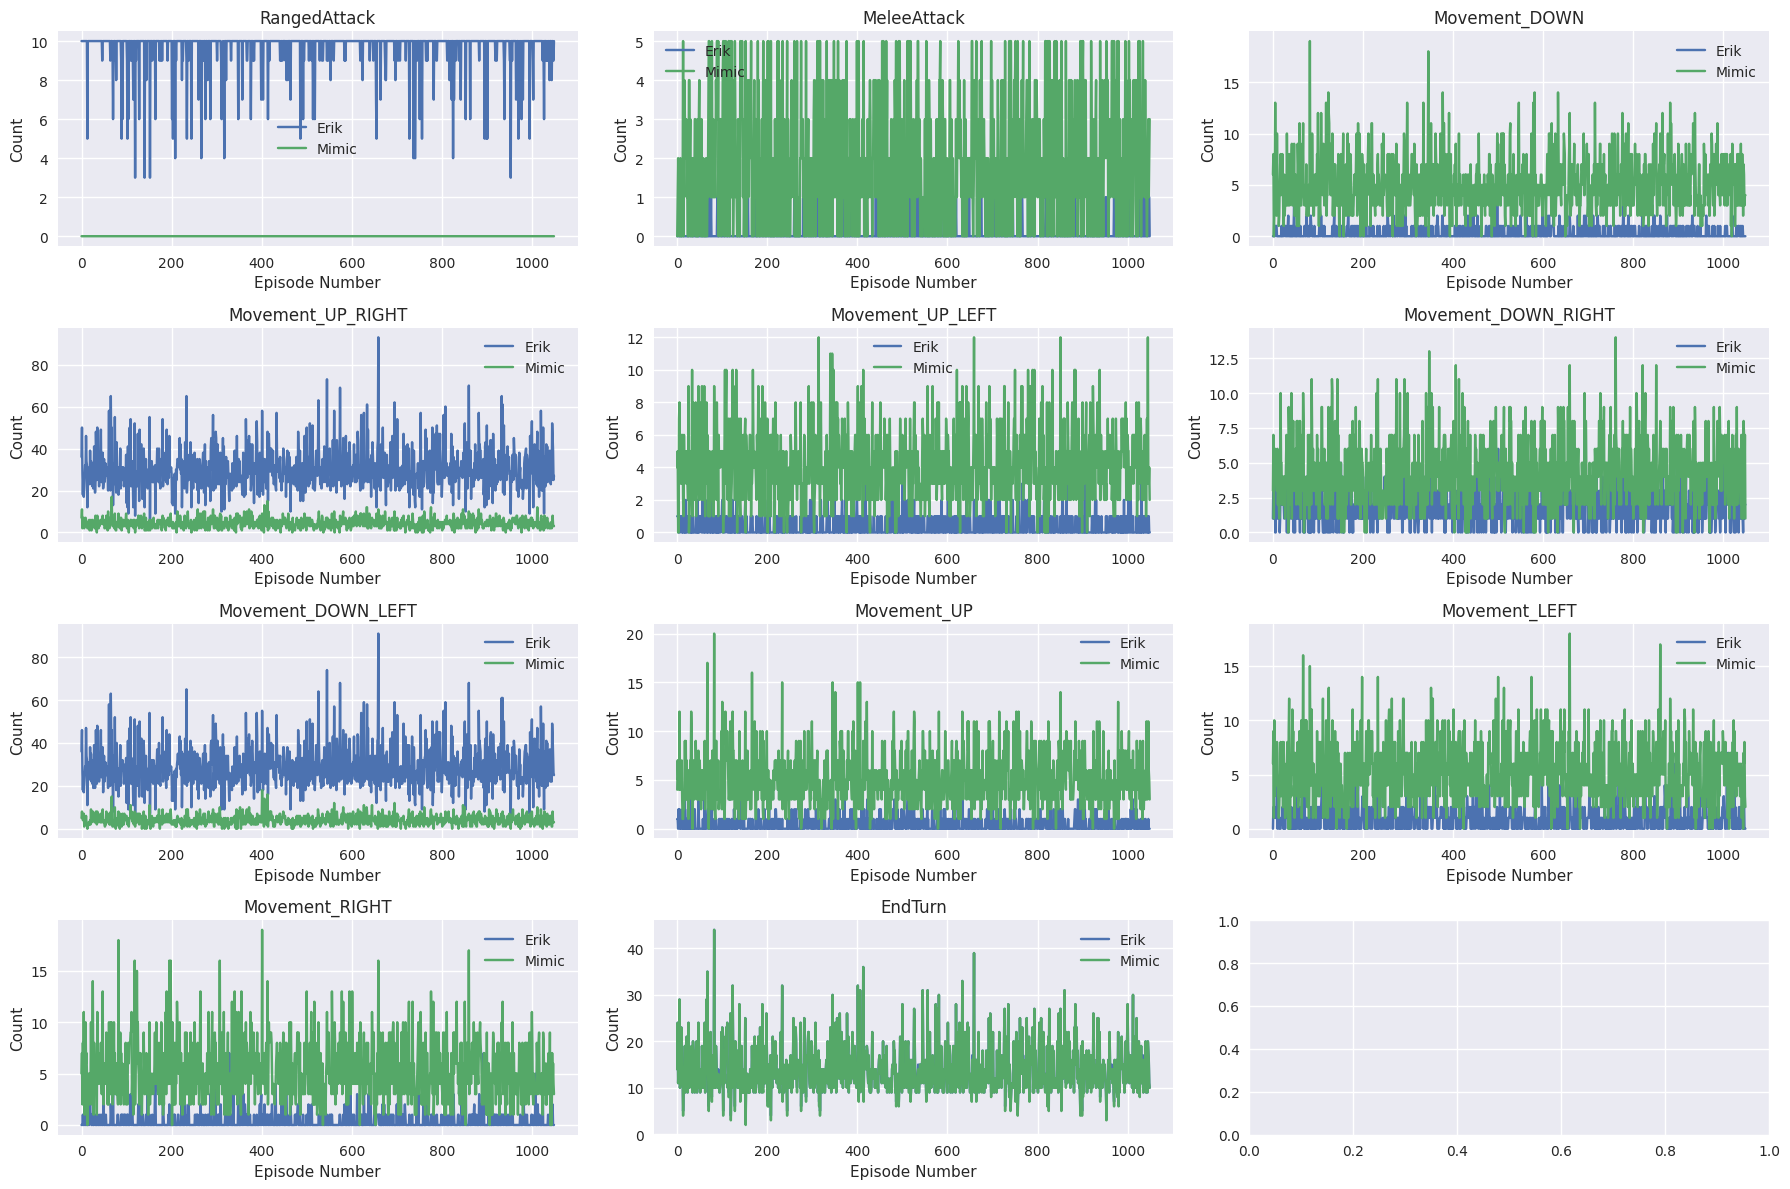

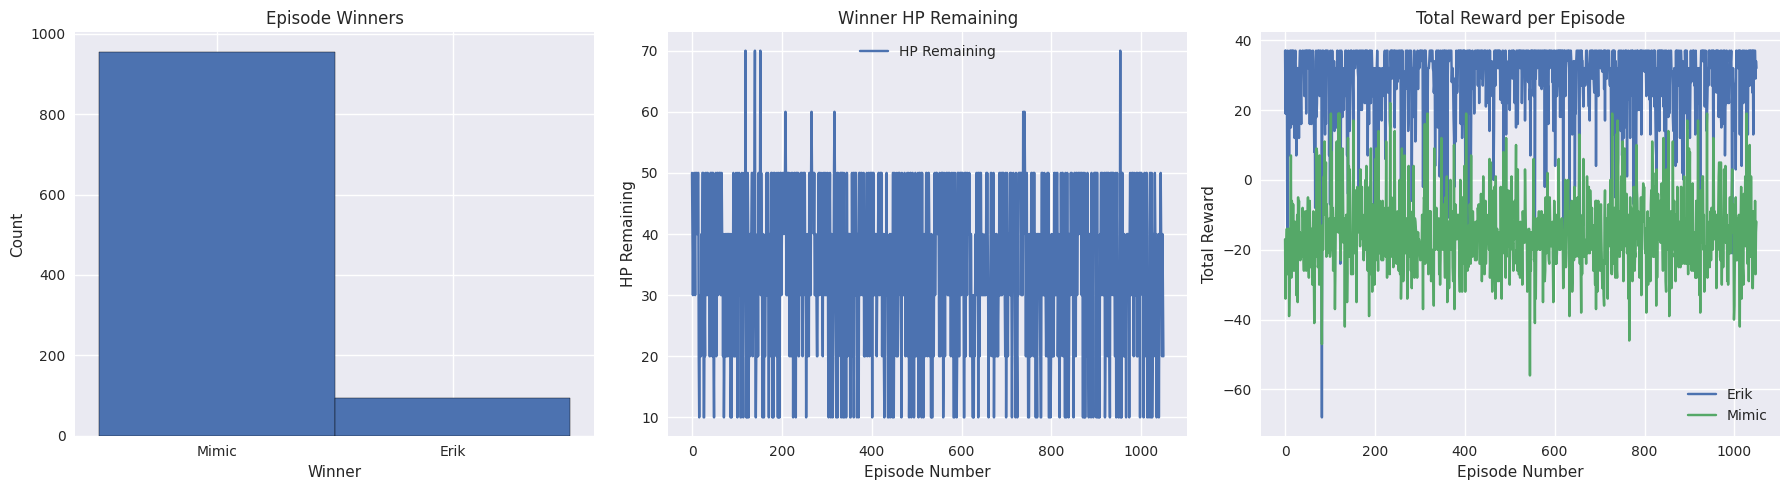

In [35]:
all_actions = set().union(
    *[actions[agentName].keys() for actions in episodes_total_actions for agentName in actions.keys()]
)
num_actions = len(all_actions)
fig, axs = plt.subplots((num_actions + 2) // 3, 3, figsize=(18, 12))

axs = axs.ravel()

for i, action in enumerate(all_actions):
    for agentName in episodes_total_actions[0].keys():
        action_data = [actions[agentName].get(action, 0) for actions in episodes_total_actions]
        axs[i].plot(episodes_number, action_data, label=agentName)
    axs[i].set_title(f"{action}")
    axs[i].set_xlabel("Episode Number")
    axs[i].set_ylabel("Count")
    axs[i].legend()

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist(episodes_winner, bins=np.arange(len(set(episodes_winner)) + 1) - 0.5, edgecolor="black")
axs[0].set_title("Episode Winners")
axs[0].set_xlabel("Winner")
axs[0].set_ylabel("Count")
axs[0].set_xticks(np.arange(len(set(episodes_winner))))
axs[0].set_xticklabels(list(set(episodes_winner)))

axs[1].plot(episodes_number, episodes_winner_hp_remaining, label="HP Remaining")
axs[1].set_title("Winner HP Remaining")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("HP Remaining")
axs[1].legend()

for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]
    axs[2].plot(episodes_number, total_reward_data, label=agentName)

axs[2].set_title("Total Reward per Episode")
axs[2].set_xlabel("Episode Number")
axs[2].set_ylabel("Total Reward")
axs[2].legend()

plt.tight_layout()
plt.show()